# 8-bit Ditherpunk

Let's make a quick demo video of our cool rendering technique and bask in nostalgia.

This notebook is broken into several sections:

0. Dependencies
1. Noise generation
2. Quantization
3. Video processing
4. Execution
5. Support tooling

## 0. Dependencies

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

import av

from time import time

from PIL import Image, ImageCms
import tqdm
from tqdm.notebook import trange, tqdm

## 1. Noise Generation

Our real-time dither solution cannot afford error-diffusion, and instead we will be using a noise pattern that is added to the rendered frame before quantization. This noise pattern will be aligned to world-space such that the noise "moves" with the viewport.

### 1.1 Bayer Filters

Unused in this tech demo, but is planned for object-highlighting, as the ordered noise stands out.

In [2]:
def bayer_pattern(exp):
    """Create a 2d Bayer pattern sized (2 ** exp, 2 ** exp)"""
    x, y = np.meshgrid(range(2 ** exp), range(2 ** exp))
    result = np.zeros_like(x)
    for i in range(exp):
        stripes_y = np.where(np.bitwise_and(y, 2 ** (exp - 1 - i)) != 0, 1, 0)
        stripes_x = np.where(np.bitwise_and(x, 2 ** (exp - 1 - i)) != 0, 1, 0)
        checker = np.bitwise_xor(stripes_x, stripes_y)
        result += np.bitwise_or(stripes_y * 2 ** (2 * i), checker * 2 ** (2 * i + 1))
    return result

### 1.2 Blue Noise

Generate blue noise using the void and cluster method as [defined by Ulichney](http://cv.ulichney.com/papers/1993-void-cluster.pdf). Implementation from [Moments in Graphics by Christoph Peters](http://momentsingraphics.de/BlueNoise.html)

In [3]:
def find_largest_void(binary_pattern, stddev):
    """This function returns the indices of the largest void in the given binary
       pattern as defined by Ulichney.
      :param binary_pattern A boolean array (should be two-dimensional although the implementation works in arbitrary dimensions).
      :param stddev The standard deviation used for the Gaussian filter
           in pixels.
      :return A flat index i such that BinaryPattern.flat[i] corresponds to the
              largest void. By definition this is a majority pixel."""
    # The minority value is always True for convenience
    if np.count_nonzero(binary_pattern) * 2 >= np.size(binary_pattern):
        binary_pattern = np.logical_not(binary_pattern)
    # Apply the Gaussian. We do not want to cut off the Gaussian at all because even
    # the tiniest difference can change the ranking. Therefore we apply the Gaussian
    # through a fast Fourier transform by means of the convolution theorem.
    filtered = np.fft.ifft2(
        ndimage.fourier_gaussian(np.fft.fft2(np.where(binary_pattern, 1.0, 0.0)), stddev)).real
    # Find the largest void
    return np.argmin(np.where(binary_pattern, 2.0, filtered))

In [4]:
def find_tightest_cluster(binary_pattern, stddev):
    """Like largest_void() but finds the tightest cluster which is a minority
       pixel by definition."""
    if (np.count_nonzero(binary_pattern) * 2 >= np.size(binary_pattern)):
        binary_pattern = np.logical_not(binary_pattern)
    FilteredArray = np.fft.ifft2(
        ndimage.fourier_gaussian(np.fft.fft2(np.where(binary_pattern, 1.0, 0.0)), stddev)).real
    return np.argmax(np.where(binary_pattern, FilteredArray, -1.0))

In [5]:
def blue_noise(shape, stddev=1.5, initial_seed_fraction=0.1):
    """Generates a blue noise dither array of the given shape using the method
       proposed by Ulichney [1993] in " The void-and-cluster method for dither array
       generation" published in Proc. SPIE 1913.
      :param shape The shape of the output array. This function works in
             arbitrary dimension, i.e. OutputShape can have arbitrary length. Though
             it is only tested for the 2D case where you should pass a tuple
             (Height,Width).
      :param stddev The standard deviation in pixels used for the
             Gaussian filter defining largest voids and tightest clusters. Larger
             values lead to more low-frequency content but better isotropy. Small
             values lead to more ordered patterns with less low-frequency content.
             Ulichney proposes to use a value of 1.5.
      :param initial_seed_fraction The only non-deterministic step in the algorithm
             marks a small number of pixels in the grid randomly. This parameter
             defines the fraction of such points. It has to be positive but less
             than 0.5. Very small values lead to ordered patterns, beyond that there
             is little change.
      :return An integer array shaped as `shape` containing each integer from 0
              to np.prod(shape)-1 exactly once."""
    
    rank = np.prod(shape)
    
    # Generate the initial binary pattern with a prescribed number of ones
    initial_one = max(1, min(int((rank - 1) / 2),
                             int(rank * initial_seed_fraction)))
    
    # Start from white noise (this is the only randomized step)
    initial_binary_pattern = np.zeros(shape, dtype=bool)
    initial_binary_pattern.flat = np.random.permutation(np.arange(rank)) < initial_one
    
    # Swap ones from tightest clusters to largest voids iteratively until convergence
    while True:
        tightest_cluster = find_tightest_cluster(initial_binary_pattern, stddev)
        initial_binary_pattern.flat[tightest_cluster] = False
        largest_void = find_largest_void(initial_binary_pattern, stddev)
        if largest_void == tightest_cluster:
            initial_binary_pattern.flat[tightest_cluster] = True
            # Nothing has changed, so we have converged
            break
        else:
            initial_binary_pattern.flat[largest_void] = True
    # Rank all pixels
    dither_array = np.zeros(shape, dtype=int)

    # Phase 1: Rank minority pixels in the initial binary pattern
    binary_pattern = np.copy(initial_binary_pattern)
    for i in range(initial_one - 1, -1, -1):
        tightest_cluster = find_tightest_cluster(binary_pattern, stddev)
        binary_pattern.flat[tightest_cluster] = False
        dither_array.flat[tightest_cluster] = i
    
    # Phase 2: Rank the remainder of the first half of all pixels
    binary_pattern = initial_binary_pattern
    for i in range(initial_one, int((rank + 1) / 2)):
        largest_void = find_largest_void(binary_pattern, stddev)
        binary_pattern.flat[largest_void] = True
        dither_array.flat[largest_void] = i
    
    # Phase 3: Rank the last half of pixels
    for i in range(int((rank + 1) / 2), rank):
        tightest_cluster = find_tightest_cluster(binary_pattern, stddev)
        binary_pattern.flat[tightest_cluster] = True
        dither_array.flat[tightest_cluster] = i
    
    return dither_array

In [6]:
def noise_analysis(arr, single_figure=True):
    """Given a 2D array of real noise values this function creates one or more
       figures with plots that allow you to analyze it, especially with respect to
       blue noise characteristics. The analysis includes the absolute value of the
       Fourier transform, the power distribution in radial frequency bands and an
       analysis of directional isotropy.
      :param A two-dimensional array.
      :param single_figure If this is True, all plots are shown in a single figure,
             which is useful for on-screen display. Otherwise one figure per plot
             is created.
      :return A list of all created figures."""
    figure_list = list()
    if single_figure:
        figure = plt.figure()
        figure_list.append(figure)

    def prepare_axes(axes, **kwargs):
        if single_figure:
            return figure.add_subplot(2, 2, axes, **kwargs)
        else:
            new_figure = plt.figure()
            figure_list.append(new_figure)
            return new_figure.add_subplot(1, 1, 1, **kwargs)

    # Plot the dither array itself
    prepare_axes(1, title="Blue noise dither array")
    plt.imshow(arr.real, cmap="gray", interpolation="nearest")
    
    # Plot the Fourier transform with frequency zero shifted to the center
    prepare_axes(2, title="Fourier transform (absolute value)", xlabel="$\\omega_x$", ylabel="$\\omega_y$")
    dft = np.fft.fftshift(np.fft.fft2(arr)) / float(np.size(arr))
    height, width = arr.shape
    shift_y, shift_x = (int(height / 2), int(width / 2))
    plt.imshow(np.abs(dft),
               cmap="viridis",
               interpolation="nearest",
               vmin=0.0, vmax=np.percentile(np.abs(dft), 99),
               extent=(-shift_x - 0.5, width - shift_x - 0.5, -shift_y + 0.5, height - shift_y + 0.5))
    plt.colorbar()

    # Plot the log Fourier transform with frequency zero shifted to the center
    prepare_axes(3, title="Fourier transform (log value)", xlabel="$\\omega_x$", ylabel="$\\omega_y$")
    dft = np.fft.fftshift(np.fft.fft2(arr)) / float(np.size(arr))
    height, width = arr.shape
    shift_y, shift_x = (int(height / 2), int(width / 2))
    plt.imshow(np.log(np.abs(dft)),
               cmap="viridis",
               interpolation="nearest",
               vmin=0.0, vmax=np.percentile(np.abs(dft), 99),
               extent=(-shift_x - 0.5, width - shift_x - 0.5, -shift_y + 0.5, height - shift_y + 0.5))
    plt.colorbar()
    


    # Plot the distribution of power over radial frequency bands
    prepare_axes(4, title="Radial power distribution",
                 xlabel="$\\sqrt{\\omega_x^2+\\omega_y^2}$")
    X, Y = np.meshgrid(range(dft.shape[1]), range(dft.shape[0]))
    X -= int(dft.shape[1] / 2)
    Y -= int(dft.shape[0] / 2)
    radial_frequency = np.asarray(np.round(np.sqrt(X ** 2 + Y ** 2)), dtype=int)
    radial_power = np.zeros((np.max(radial_frequency) - 1,))
    dft[int(dft.shape[0] / 2), int(dft.shape[1] / 2)] = 0.0
    for i in range(radial_power.shape[0]):
        radial_power[i] = np.sum(np.where(radial_frequency == i, np.abs(dft), 0.0)) / np.count_nonzero(
            radial_frequency == i)
    plt.plot(np.arange(np.max(radial_frequency) - 1) + 0.5, radial_power)
    
    # Plot the distribution of power over angular frequency ranges
    prepare_axes(5, title="Anisotropy (angular power distribution)", aspect="equal",
                 xlabel="$\\omega_x$",
                 ylabel="$\\omega_y$")
    circular_mask = np.logical_and(0 < radial_frequency, radial_frequency < int(min(dft.shape[0], dft.shape[1]) / 2))
    normalized_x = np.asarray(X, dtype=float) / np.maximum(1.0, np.sqrt(X ** 2 + Y ** 2))
    normalized_y = np.asarray(Y, dtype=float) / np.maximum(1.0, np.sqrt(X ** 2 + Y ** 2))
    binning_angle = np.linspace(0.0, 2.0 * np.pi, 33)
    angular_power = np.zeros_like(binning_angle)
    for i, angle in enumerate(binning_angle):
        dot_product = normalized_x * np.cos(angle) + normalized_y * np.sin(angle)
        full_mask = np.logical_and(circular_mask, dot_product >= np.cos(np.pi / 32.0))
        angular_power[i] = np.sum(np.where(full_mask, np.abs(dft), 0.0)) / np.count_nonzero(full_mask)
    mean_angular_power = np.mean(angular_power[1:])
    dense_angle = np.linspace(0.0, 2.0 * np.pi, 256)
    plt.plot(np.cos(dense_angle) * mean_angular_power, np.sin(dense_angle) * mean_angular_power, color=(0.7, 0.7, 0.7))
    plt.plot(np.cos(binning_angle) * angular_power, np.sin(binning_angle) * angular_power)
    
    return figure_list


def plot_binary_patterns(arr, rows, cols):
    """This function creates a figure with a grid of thresholded versions of the
       given 2D noise texture. It assumes that each value from 0 to
       np.size(Texture)-1 is contained exactly once.
      \return The created figure.
      \note For the plots to show you have to invoke plt.show()."""
    fig = plt.figure()
    pattern = rows * cols + 1
    for i in range(1, pattern):
        fig.add_subplot(rows, cols, i, xticks=[], yticks=[])
        plt.imshow(np.where(arr * pattern < i * np.size(arr), 1.0, 0.0), cmap="gray",
                   interpolation="nearest")
    return fig

In [9]:
noise = blue_noise((64, 64), 1.5)

<Figure size 432x288 with 0 Axes>

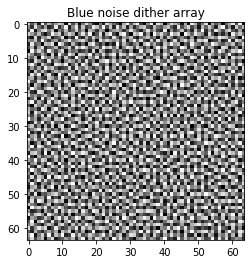

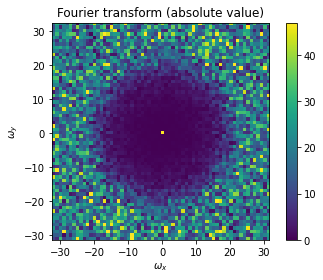

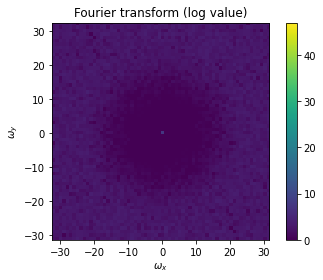

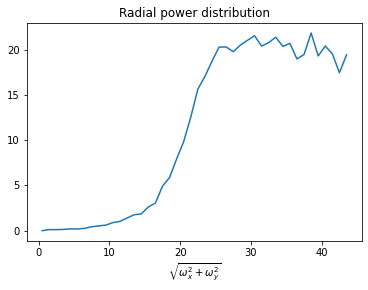

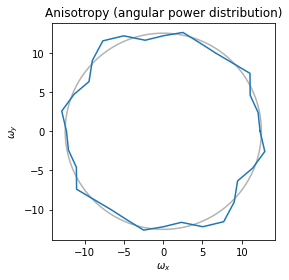

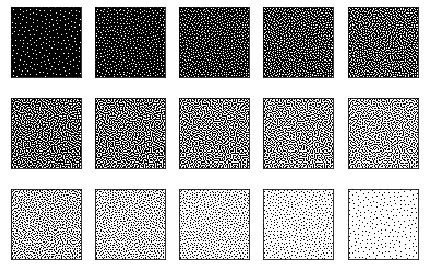

In [10]:
plt.clf()
noise_analysis(noise, False)
plot_binary_patterns(noise, 3, 5)
plt.tight_layout()
plt.show()

## 2. Quantization

The Dither Array is now ready to be used for either bitonal or multilevel dithering. In general the input image signal will have `NIL` (number of input levels) discrete values, and the desired output signal will have `NOL` (number of output levels) discrete values. The details of an efficient implementation of multilevel dithering that allows any value of `NIL` and `NOL` (where `NOL` is less than or equal to `NIL`) is given in [10]. A key property of this method is the resulting dithered average output is always equal to the input. The expressions for proper normalization is summarized here.

We define a Quantizer with equal steps of size

> ΔQ = (`NIL` - 1) / (`NOL` - 1)

The elements of the Dither Array are normalized by means of the following relation:

> _Rank'_ = int{ ΔQ / (MN) * (_Rank_ + 1/2) }

where "int{}" represents integer truncation, or the rounding-down operation.

For a given input, the output is then computed as

>  output = Quantizer{ input + _Rank'_ }.

The value _Rank'_ is the element of the Dither Array with the same x and y address, or index, as input and output, modularly adjusted by Mand N. That is, for a given image address (x, y), the index to the Dither Array is

> (x modulo M, y modulo N).

For the important special case of bitonal output, that is when `NOL` = 2, the computation can be
simplified as

> if(input > _Rank'_) then output= 1 else output= 0.

This method of dithering will produce a uniformly spaced distribution of dithered levels, that preserves
the average value of the input.

## 3. Video

In this section, we define methods for processing video streams.

In [12]:
def frames(path):
    """A generator that quickly yields every frame in a video."""
    container = av.open(path)
    # Enable automatic threaded decoding     
    container.streams.video[0].thread_type = 'AUTO'
    for frame in container.decode(video=0):
        yield np.asarray(frame.to_image())

Quantizing in the RGB color spaces leads to washed-out results, losing the original vibrancy of our image. Instead, we first convert our frames to [CIELAB](https://en.m.wikipedia.org/wiki/CIELAB_color_space) color such that our K-means clustering algorithm will operate in perceptually uniform color space.

Future enhancements are planned to use improved color models that account for the [Helmholtz–Kohlrausch effect](https://en.wikipedia.org/wiki/Helmholtz–Kohlrausch_effect).

In [13]:
srgb_profile = ImageCms.createProfile("sRGB")
lab_profile  = ImageCms.createProfile("LAB")

In [14]:
rgb2lab = ImageCms.buildTransformFromOpenProfiles(srgb_profile, lab_profile, "RGB", "LAB")
lab2rgb = ImageCms.buildTransformFromOpenProfiles(lab_profile, srgb_profile, "LAB", "RGB")

In [62]:
def count_frames(path, length=sys.maxsize):
    frames = 0
    with av.open(path) as container:
        stream = container.streams.video[0]
        for frame in container.decode(stream):
            if frame.time > length:
                return frames
            frames += 1
    return frames


def transcode(path, into, callback, length=sys.maxsize, scale=1):
    container_in = av.open(path)
    # Enable automatic threaded decoding     
    container_in.streams.video[0].thread_type = 'AUTO'

    container_out = av.open(into, mode='w')

    stream_in = container_in.streams.video[0]
    stream_out = container_out.add_stream('libx265', rate=stream_in.rate)
    stream_out.width = stream_in.width / scale
    stream_out.height = stream_in.height / scale
    stream_out.options = {'crf': '3'}

    print(f"Counting frames from {path}")
    frame_count = count_frames(path, length)
    print(f"Processing frames")
    pbar = tqdm(total=frame_count)

    last_time = time()
    for frame_in in container_in.decode(video=0):
        if length and frame_in.time >= length:
            break
        
        f0 = time()
        frame_rgb = frame_in.reformat(stream_in.width / scale, stream_in.height / scale).to_image()
        f1 = time()
        
        l0 = time()
        frame_lab = ImageCms.applyTransform(frame_rgb, rgb2lab)
        l1 = time()
        
        c0 = time()
        frame_np = np.array(frame_lab)
        c1 = time()
        
        p0 = time()
        frame_np = callback(frame_np)
        p1 = time()

        i0 = time()
        new_image = Image.fromarray(frame_np, 'LAB')
        i1 = time()
        
        c2 = time()
        new_image = ImageCms.applyTransform(new_image, lab2rgb)
        c3 = time()
        
        v0 = time()
        frame_out = av.VideoFrame.from_image(new_image)
        v1 = time()
        
        e0 = time()
        for packet in stream_out.encode(frame_out):
            container_out.mux(packet)
        e1 = time()
        
#         print(f"Frame #{frame_in.index} processed in {time() - last_time:0.3f}")
#         print(f"  - {f1 - f0:0.3f}s ->Image")
#         print(f"  - {l1 - l0:0.3f}s ->LAB")
#         print(f"  - {c1 - c0:0.3f}s ->numpy")
#         print(f"  - {p1 - p0:0.3f}s ->process")
#         print(f"  - {i1 - i0:0.3f}s ->Image")
#         print(f"  - {c3 - c2:0.3f}s ->RGB")
#         print(f"  - {v1 - v0:0.3f}s ->VideoFrame")
#         print(f"  - {e1 - e0:0.3f}s ->encode")

        last_time = time()
        pbar.update()

    container_in.close()
    container_out.close()

In [66]:
def rolling_quantizer(n_colors, sample_ratio=1.0):
    """Sample a portion of a frame to update our k-means generated palette"""
    cluster_centers = 'k-means++'
    buffer = None
    
    def process(image):
        nonlocal buffer
        nonlocal cluster_centers

        kmeans_kwargs = {
            'n_clusters': n_colors, 
            'init': cluster_centers,
            'batch_size': 4096,
            'n_init': 1,
        }
        if buffer is None:
            kmeans_kwargs['n_init'] = 10
            kmeans_kwargs['max_iter'] = 1000
        kmeans = MiniBatchKMeans(**kmeans_kwargs)
    
        # Load Image and transform to a 2D numpy array.
        w, h, d = tuple(image.shape)
        image_array = np.reshape(image, (w * h, d))

        # Update target palette
        t0 = time()
        n_samples = int(sample_ratio * w * h)
        new_samples = shuffle(image_array, n_samples=n_samples)
        if buffer is None:
            buffer = new_samples
        else:
            buffer = np.vstack((buffer, new_samples))

        # Only keep 16 frames of samples
        if len(buffer) > (int(1/sample_ratio) * n_samples):
            buffer = np.delete(buffer, range(n_samples), axis=0)
        
        model = kmeans.fit(buffer)
        t1 = time()
        cluster_centers = kmeans.cluster_centers_

        # Resample image according to new palette
        t2 = time()
        # TODO Dither to custom palette
        labels = model.predict(image_array)
        t3 = time()

        result = model.cluster_centers_[labels].reshape(w, h, -1)
#         print(f"Quantized in {t3 - t0:0.3f}s (Fit: {t1 - t0:0.3f}s Predict: {t3 - t2:0.3f}s) after {model.n_steps_}")

        return result.astype(image.dtype)
    
    return process

## 4. Execution

Let's transcode a video using our rolling quantizer.

In [ ]:
length = sys.maxsize
sample_ratio = 1.0/16
scale = 4
# transcode('mass_effect_3.webm','quantizer_8.mp4', quantizer(8))
transcode('mass_effect_3.webm','rolling_quantizer_8.mp4', 
          rolling_quantizer(8, sample_ratio), 
          length=length, scale=scale)

## 5. Support tooling

In [98]:
def save_ldr(arr, path):
    """This function stores the given texture to a standard low-dynamic range png
       file with four channels and 8 bits per channel.
      :param Texture An array of shape (Height,Width) or (Height,Width,nChannel).
             The former is handled like (Height,Width,1). If nChannel>4 the
             superfluous channels are ignored. If nChannel<4 the data is expanded.
             The alpha channel is set to 255, green and blue are filled with black
             or with duplicates of red if nChannel==1. It is assumed that each
             channel contains every integer value from 0 to Width*Height-1 exactly
             once. The range of values is remapped linearly to span the range from 0
             to 255.
      :param OutputPNGFilePath The path to the output png file including the file
             format extension."""
    # Scale the array to an LDR version
    nRank = arr.shape[0] * arr.shape[1]
    arr = np.asarray((arr * 256) // nRank, dtype=np.uint8)
    # Get a three-dimensional array
    if len(arr.shape) < 3:
        arr = arr[:, :, np.newaxis]
    # Generate channels as needed
    if arr.shape[2] == 1:
        arr = np.dstack([arr] * 3 + [255 * np.ones_like(arr[:, :, 0])])
    elif arr.shape[2] == 2:
        arr = np.dstack([arr[:, :, 0], arr[:, :, 1]] + [np.zeros_like(arr[:, :, 0])] + [
            255 * np.ones_like(arr[:, :, 0])])
    elif arr.shape[2] == 3:
        arr = np.dstack(
            [arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]] + [255 * np.ones_like(arr[:, :, 0])])
    elif arr.shape[2] > 4:
        arr = arr[:, :, :4]
    # Save the image
    png.from_array(arr, "RGBA;8").save(path)


def save_hdr(arr, path):
    """This function stores the given texture to an HDR png file with 16 bits per
       channel and the specified number of channels.
      :param arr An array of shape (Height,Width) or (Height,Width,nChannel).
             The former is handled like (Height,Width,1). It is assumed that each
             channel contains each integer value from 0 to Width*Height-1 exactly
             once. The range of values is remapped linearly to span the range from
             0 to 65535 supported by the output format. nChannel can be 1, 2, 3 or
             4.
      :param path The path to the output png file including the file
             format extension."""
    # Scale the array to an HDR version
    n_rank = arr.shape[0] * arr.shape[1]
    arr = np.asarray((np.asarray(arr, dtype=np.uint64) * (2 ** 16)) // n_rank, dtype=np.uint16)
    # Get a three-dimensional array
    if len(arr.shape) < 3:
        arr = arr[:, :, np.newaxis]
    # Save the image
    mode = ["L", "LA", "RGB", "RGBA"][arr.shape[2] - 1] + ";16"
    png.from_array(arr, mode).save(path)


def save_noise_scales(random_seed_index_list=range(1),
                      resolution_min=16, resolution_max=1024,
                      channel_count=[1, 2, 3, 4],
                      stddev=1.5):
    """This function generates a database of blue noise textures for all sorts of
       use cases. It includes power-of-two resolutions from MinResolution**2 up
       to MaxResolution**2. Textures are generated with each given number of
       channels. Each texture is generated multiple times using different random
       numbers per entry in random_seed_index_list and the entries become part of the
       file name. stddev forwards to blue_noise(). The
       results are stored as LDR and HDR files to a well-organized tree of
       of directories."""
    res = resolution_min
    while res <= resolution_max:
        path = "%d_%d" % (res, res)
        if not path.exists(path):
            makedirs(path)
        for nChannel in channel_count:
            for i in random_seed_index_list:
                arr = np.dstack(
                    [blue_noise((res, res), stddev) for i in range(nChannel)])
                ldr_format = ["LLL1", "RG01", "RGB1", "RGBA"][nChannel - 1]
                hdr_format = ["L", "LA", "RGB", "RGBA"][nChannel - 1]
                save_ldr(arr, path.join(path, "LDR_%s_%d.png" % (ldr_format, i)))
                save_hdr(arr, path.join(path, "HDR_%s_%d.png" % (hdr_format, i)))
                print("%d*%d, %s, %d" % (res, res, ldr_format, i))
        res *= 2